In [229]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)
%matplotlib inline

Đọc và kiểm tra dữ liệu

In [230]:
dataset_ratings=pd.read_csv("ratings_Beauty.csv")
dataset_ratings.info()
dataset_ratings.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493800 entries, 0 to 493799
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   UserId     493800 non-null  object 
 1   ProductId  493800 non-null  object 
 2   Rating     493800 non-null  float64
 3   Timestamp  493800 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 15.1+ MB


(493800, 4)

EDA

In [231]:
data_set_buffer = dataset_ratings.drop('Timestamp',axis=1)
#consider chỉ chiếm 10% dữ liệu
data_set_buffer = data_set_buffer.sample(frac=0.1)
del dataset_ratings

In [232]:
#Kiểm tra dữ liệu có NULL hay N/A hay không
data_set_buffer.isna().sum()
data_set_buffer.isnull().sum()

UserId       0
ProductId    0
Rating       0
dtype: int64

In [233]:
data_set_buffer.describe().T

,count,mean,std,min,25%,50%,75%,max
Rating,49380.0,4.079486,1.333577,1.0,3.0,5.0,5.0,5.0


In [234]:
data_set_buffer.Rating.describe().T

count    49380.000000
mean         4.079486
std          1.333577
min          1.000000
25%          3.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: Rating, dtype: float64

In [235]:
data_set_buffer.groupby('UserId')['Rating'].count().sort_values(ascending=False)

UserId
ALNFHVS3SC4FV     11
A34BZM6S9L7QI4     9
A3LJLRIZL38GG3     9
A34GQ3JF4BGFYV     9
A2QDOJFFLFGF18     9
                  ..
A2A5D19RZXA1TQ     1
A2A5DABY0G4TUB     1
A2A5DGNAJRHSH      1
A2A5DIWBWDNLKV     1
AZZZLM1E5JJ8C      1
Name: Rating, Length: 46228, dtype: int64

Biểu đồ xem số lượng rating

In [236]:
sns.set(style="white", palette="tab10", color_codes=True)

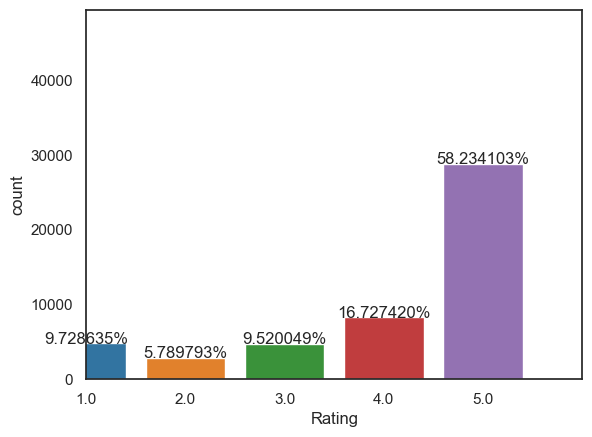

In [237]:
ax = sns.countplot(data=data_set_buffer,x='Rating')
ax.set_ylim(0, len(data_set_buffer))
ax.set_xlim(0, 5)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:%}'.format(height/float(len(data_set_buffer))),
            ha="center") 
plt.show()

Quan sát: 58% người dùng đã xếp hạng 5. Vì vậy, chúng tôi có số lượng 5 xếp hạng cao nhất.

In [238]:
data_set_buffer_with_threshold50=data_set_buffer.groupby("ProductId").filter(lambda x:x['Rating'].count() >=50)
del data_set_buffer

Xây dựng mô hình gợi ý sản phẩm

In [239]:
#Chia dữ liệu thành tập train test
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data_set_buffer_with_threshold50, test_size = 0.3)
train_data.head()

,UserId,ProductId,Rating
244271,A11A7XXU26O7O1,B008U1Q4DI,5.0
241384,A15U1YKIP7B9M9,B008TBTA6C,4.0
243340,A2H84JCWBKMWYF,B008U12YV4,5.0
277147,A2FCDOOR9OE2XX,B009FIF1RU,2.0
317295,A2TFBHX8UJSQ9,B00A51LI1O,2.0


In [240]:
# Số lượng user_id cho mỗi sản phẩm duy nhất làm điểm đề xuất
train_data_grouped = train_data.groupby('ProductId').agg({'UserId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'UserId': 'noofusers'},inplace=True)
train_data_grouped.head()

,ProductId,noofusers
0,B005X2F7KI,35
1,B005XIDZHO,39
2,B005Y6F4WO,44
3,B00639DLV2,59
4,B0067F28ZW,39


In [241]:
#Đếm tổng số lượng đánh giá từng sản phẩm
train_data_grouped_rating= train_data.groupby(['ProductId'])['Rating'].sum().reset_index()
train_data_grouped_rating.rename(columns = {'Rating': 'ratingsum'},inplace=True)
train_data_grouped_rating.head()

,ProductId,ratingsum
0,B005X2F7KI,145.0
1,B005XIDZHO,128.0
2,B005Y6F4WO,191.0
3,B00639DLV2,261.0
4,B0067F28ZW,159.0


In [242]:
train_data_grouped_users = train_data.groupby('ProductId').agg({'UserId': 'count'}).reset_index()
train_data_grouped_users.rename(columns = {'UserId': 'noofuser'},inplace=True)
train_data_grouped_users.head()

,ProductId,noofuser
0,B005X2F7KI,35
1,B005XIDZHO,39
2,B005Y6F4WO,44
3,B00639DLV2,59
4,B0067F28ZW,39


In [243]:
train_data_merged_grouped = pd.merge(train_data_grouped_rating, train_data_grouped_users, on='ProductId')
train_data_merged_grouped.head()

,ProductId,ratingsum,noofuser
0,B005X2F7KI,145.0,35
1,B005XIDZHO,128.0,39
2,B005Y6F4WO,191.0,44
3,B00639DLV2,261.0,59
4,B0067F28ZW,159.0,39


In [244]:
train_data_merged_grouped['averagerating']= train_data_merged_grouped['ratingsum']/train_data_merged_grouped['noofuser']
train_data_merged_grouped.head()

,ProductId,ratingsum,noofuser,averagerating
0,B005X2F7KI,145.0,35,4.142857
1,B005XIDZHO,128.0,39,3.282051
2,B005Y6F4WO,191.0,44,4.340909
3,B00639DLV2,261.0,59,4.423729
4,B0067F28ZW,159.0,39,4.076923


In [245]:
train_data_merged_grouped.sort_values('averagerating',ascending=False)

,ProductId,ratingsum,noofuser,averagerating
18,B007Q0WW0S,271.0,56,4.839286
42,B00CNOUZE2,252.0,53,4.754717
44,B00D9NV20C,175.0,37,4.729730
33,B009GIOVKC,202.0,43,4.697674
27,B008TBTA6C,165.0,36,4.583333
8,B006IBM21K,417.0,91,4.582418
41,B00CFRBIC0,259.0,58,4.465517
35,B009HULKLW,244.0,55,4.436364
3,B00639DLV2,261.0,59,4.423729
14,B006ZA0A5Y,176.0,40,4.400000


In [246]:
# Top 5 sản phẩm phổ biến
train_data_merged_grouped.sort_values('averagerating',ascending=False).head(5)

,ProductId,ratingsum,noofuser,averagerating
18,B007Q0WW0S,271.0,56,4.839286
42,B00CNOUZE2,252.0,53,4.754717
44,B00D9NV20C,175.0,37,4.729730
33,B009GIOVKC,202.0,43,4.697674
27,B008TBTA6C,165.0,36,4.583333


In [247]:
del train_data_grouped
del train_data_grouped_rating
del train_data_merged_grouped

In [248]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split

In [249]:
#Tải khung dữ liệu đến bất ngờ. Quan sát: Có lỗi bộ nhớ nên chỉ xem xét gần 1% của tập dữ liệu gốc !!
data_set_buffer_with_threshold50 = data_set_buffer_with_threshold50.sample(frac=0.01)
data = Dataset.load_from_df(data_set_buffer_with_threshold50,Reader(rating_scale=(1, 5)))
trainset, testset = train_test_split(data, test_size=0.25)

In [250]:
# Sử dụng user_based true / false để chuyển đổi giữa lọc cộng tác dựa trên người dùng hoặc dựa trên mục
userusercollaborativefiltering = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': True})
userusercollaborativefiltering.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [251]:
trainset.n_users

24

In [252]:
test_pred = userusercollaborativefiltering.test(testset)


In [253]:
#RMSE
print("User-based Model : Test Set RMSE score")
accuracy.rmse(test_pred, verbose=True)


User-based Model : Test Set RMSE score
RMSE: 0.8858


0.8858454843945543